###Se busca entrenar una red neuronal para predecir el valor de cualquier acción para mañana. Busque valores de la acción y de otras tres variables que considere influyen en el valor de esa acción.

####Carlos Felipe Sánchez
####Juan David González


Empezamos el caso de estudio con una acción específica, en este caso tomaremos el stock de TESLA.
Usaremos como valores relevantes el precio histórico de la acción, el volumen de negociación, el precio de cierre de la acción, y el índice de fuerza relativa.
Esta primera sección de código nos permite importar los datos directamente del repositorio de Yahoo Finance.

In [19]:
import yfinance as yf
import pandas as pd
symbol = 'TSLA'  # Símbolo de la acción buscada.
start_date = '2022-08-01'
end_date = '2023-08-01'

# Descarga los datos históricos con el precio de cierre ajustado y el volumen
data = yf.download(symbol, start=start_date, end=end_date, actions=True)

# Accede al precio de cierre ajustado (Adj Close) y al volumen
adj_close = data['Adj Close']
volume = data['Volume']

# Función para calcular el RSI
def calculate_rsi(data, window=14):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

# Calcula el RSI
rsi = calculate_rsi(data['Close'])
rsi = rsi.dropna()
# Calcula la Variación Diaria (Daily Change)
daily_change = adj_close.pct_change() * 100  # Expresado en porcentaje

# Agrega la variación diaria y el RSI como una nueva columna en el DataFrame
data['Daily Change'] = daily_change
data["RSI"] = rsi
data = data.dropna()
# Imprime los primeros registros de cada variable
print("Precio de Cierre Ajustado (Adj Close):")
print(adj_close.head())
print("\nVolumen:")
print(volume.head())
print("\nRSI:")
print(rsi.head())
print("\nVariación Diaria (Daily Change):")
print(data['Daily Change'].head())




[*********************100%%**********************]  1 of 1 completed
Precio de Cierre Ajustado (Adj Close):
Date
2022-08-01    297.276672
2022-08-02    300.586670
2022-08-03    307.396667
2022-08-04    308.633331
2022-08-05    288.170013
Name: Adj Close, dtype: float64

Volumen:
Date
2022-08-01    117042900
2022-08-02     95577600
2022-08-03     80091000
2022-08-04     72256200
2022-08-05    113172900
Name: Volume, dtype: int64

RSI:
Date
2022-08-18    53.140436
2022-08-19    49.679804
2022-08-22    44.593037
2022-08-23    44.441058
2022-08-24    44.104125
Name: Close, dtype: float64

Variación Diaria (Daily Change):
Date
2022-08-18   -0.370622
2022-08-19   -2.048185
2022-08-22   -2.276402
2022-08-23    2.255850
2022-08-24    0.217013
Name: Daily Change, dtype: float64


Ahora, vamos a crear la red Neuronal que procese estos datos para la predicción. Para esto necesitaremos las librerías de modelos de redes neuronales de Scikit, y la librería Tensorflow.


In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras import layers

In [21]:

# División de datos en conjuntos de entrenamiento, validación y prueba
X = data[['Adj Close', 'Volume', 'RSI', 'Daily Change']]
y = data['Adj Close']  # Puedes cambiar esto si deseas predecir otra columna

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



In [22]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Usamos Keras para la construcción del modelo

In [25]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Capa de salida para la predicción
])


# Compilación del modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

# Evaluación del modelo en el conjunto de prueba
loss, mae = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, MAE: {mae}")
y_pred = model.predict(X_test)

Epoch 1/100
6/6 [==============================] - 2s 110ms/step - loss: 45684.2734 - mae: 207.7807 - val_loss: 44270.1133 - val_mae: 204.0908
Epoch 2/100
6/6 [==============================] - 0s 31ms/step - loss: 45577.6055 - mae: 207.5306 - val_loss: 44163.1406 - val_mae: 203.8337
Epoch 3/100
6/6 [==============================] - 0s 27ms/step - loss: 45468.0938 - mae: 207.2724 - val_loss: 44040.8906 - val_mae: 203.5419
Epoch 4/100
6/6 [==============================] - 0s 29ms/step - loss: 45340.3164 - mae: 206.9717 - val_loss: 43900.6641 - val_mae: 203.2086
Epoch 5/100
6/6 [==============================] - 0s 28ms/step - loss: 45197.2969 - mae: 206.6366 - val_loss: 43740.9922 - val_mae: 202.8317
Epoch 6/100
6/6 [==============================] - 0s 53ms/step - loss: 45025.4805 - mae: 206.2427 - val_loss: 43560.0156 - val_mae: 202.4065
Epoch 7/100
6/6 [==============================] - 0s 42ms/step - loss: 44831.2578 - mae: 205.7925 - val_loss: 43348.8594 - val_mae: 201.9091
Epoch

Con el modelo ya ejecutado, podemos obtener gráficas de su comportamiento.

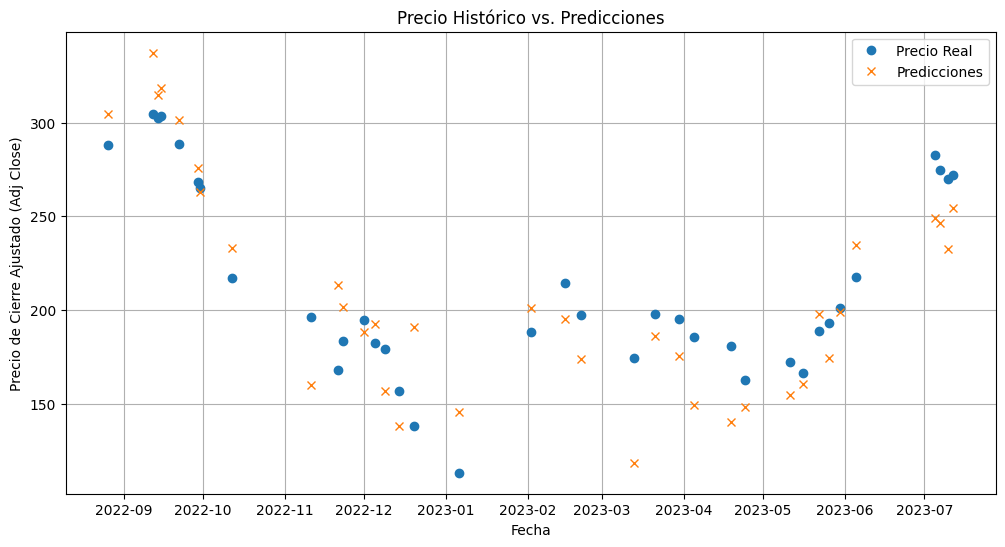

In [32]:
import matplotlib.pyplot as plt

# Supongamos que 'y_test' son los valores reales y 'y_pred' son las predicciones de tu modelo
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Precio Real', marker='o', linestyle='None')
plt.plot(y_test.index, y_pred, label='Predicciones', marker='x', linestyle='None')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre Ajustado (Adj Close)')
plt.title('Precio Histórico vs. Predicciones')
plt.legend()
plt.grid(True)
plt.show()


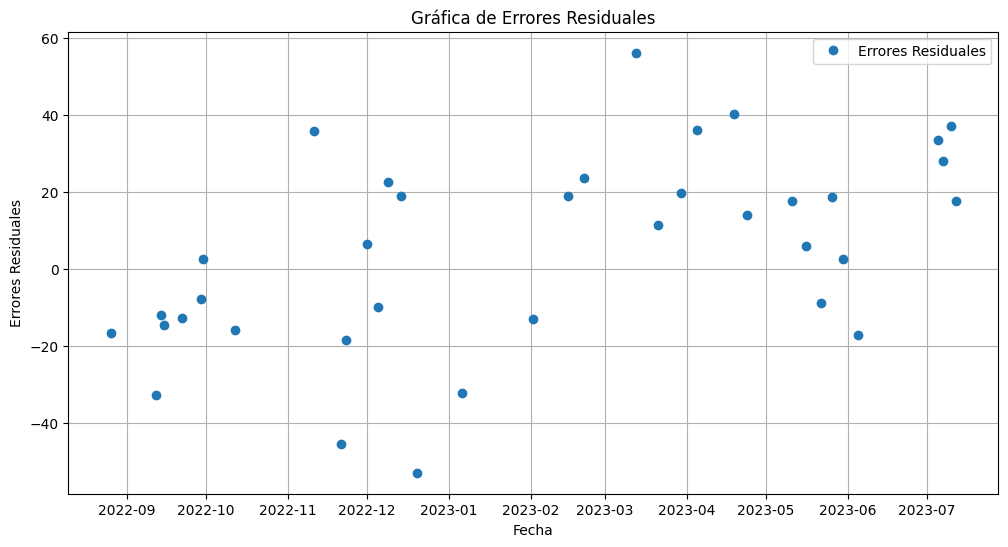

In [33]:
residuals = y_test.values - y_pred.ravel()
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, residuals, label='Errores Residuales', marker='o', linestyle='None')
plt.xlabel('Fecha')
plt.ylabel('Errores Residuales')
plt.title('Gráfica de Errores Residuales')
plt.legend()
plt.grid(True)
plt.show()


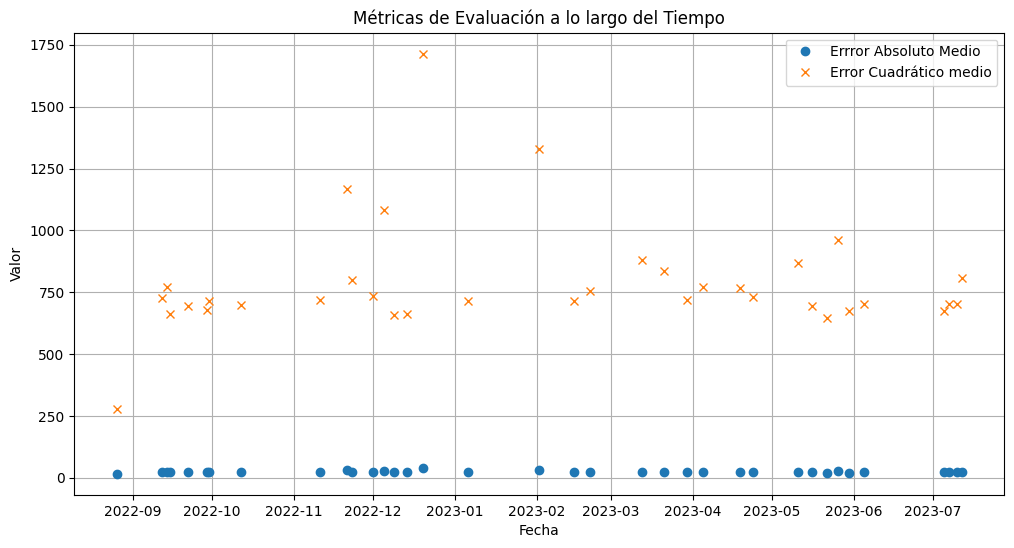

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_values = [mean_absolute_error(y_test[:i], y_pred[:i]) for i in range(1, len(y_test) + 1)]
mse_values = [mean_squared_error(y_test[:i], y_pred[:i]) for i in range(1, len(y_test) + 1)]

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, mae_values, label='Errror Absoluto Medio', marker='o', linestyle='None')
plt.plot(y_test.index, mse_values, label='Error Cuadrático medio', marker='x', linestyle='None')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Métricas de Evaluación a lo largo del Tiempo')
plt.legend()
plt.grid(True)
plt.show()